2024-10-27 14:15:58,028 - INFO - Fetching data from DB ['data_digi_sa']
2024-10-27 14:15:58,314 - INFO - Table Name: data_digi_sa
2024-10-27 14:15:58,977 - INFO - DB read duration: 0.66 seconds
2024-10-27 14:15:58,978 - INFO - Data successfully exported from PostgreSQL DB Table: data_digi_sa
2024-10-27 14:15:58,980 - INFO - Database connection closed.
2024-10-27 14:15:58,982 - INFO - Analysing Data Set: data_digi_sa
2024-10-27 14:15:58,983 - INFO - Basic Information for Data Set or Table
2024-10-27 14:15:58,984 - INFO - 
####################################################################
2024-10-27 14:15:58,986 - INFO - Name of Data Set: data_digi_sa
2024-10-27 14:15:58,988 - INFO - 
####################################################################
2024-10-27 14:15:58,991 - INFO - Top rows in Data Set:   country_name country_code  \
0       Africa          AFR   
1       Africa          AFR   

                                      indicator_name  indicator_code  year  \
0     Mobi

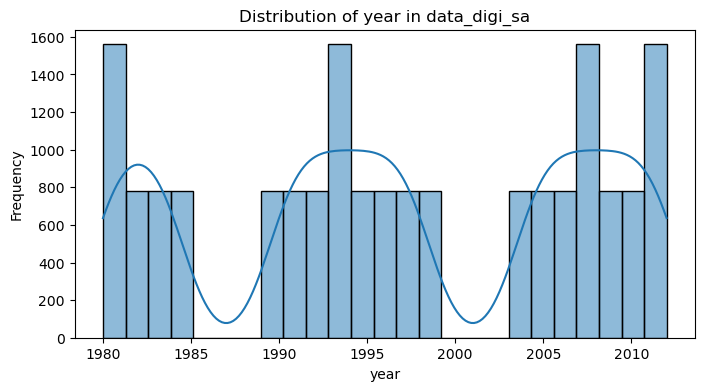

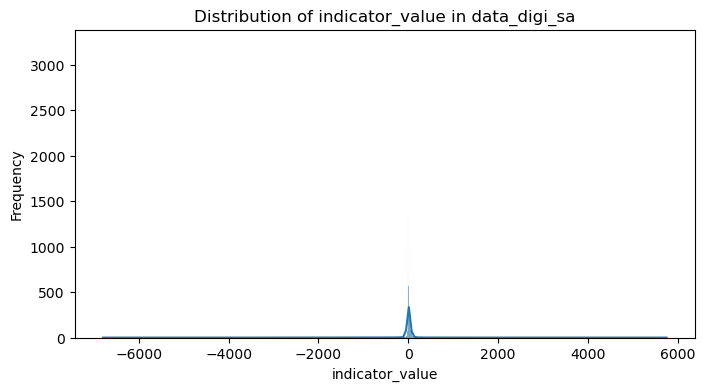

In [25]:
# Let us import the required libraries
import io
import os
import time
import pandas as pd
import logging
import seaborn as sns
from dotenv import dotenv_values
from psycopg2 import DatabaseError, InterfaceError, OperationalError
from sqlalchemy import create_engine, text
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor  


# Load the configuration from .env into context
config = dotenv_values(".env")

# DB Variables
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_user = config['POSTGRES_USER']
pg_password = config['POSTGRES_PASS']

# Create the connection string
DATABASE_URL = f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}"

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)



table_names= ['data_digi_sa']## dimensions and measures  ## 'data_digi_sa', 'countries_digi_sa', 'indicators_digi_sa'

table_data = {}

class analyseDataSet:    
    def perform_db_fetch(self, DATABASE_URL, table_names):
        logging.info(f"Fetching data from DB {table_names}")        
        try:
            engine = create_engine(DATABASE_URL, connect_args={"connect_timeout": 20})
            with engine.connect() as connection:
                for table_name in table_names:
                    logging.info(f"Table Name: {table_name}")
                    start_time = time.time()
                    table_data[table_name]=pd.read_sql_table(table_name, engine, schema=pg_schema, index_col=None, coerce_float=True, parse_dates=None, columns=None, chunksize=None)                    
                    end_time = time.time()
                    logging.info(f"DB read duration: {end_time - start_time:.2f} seconds")
                    logging.info(f"Data successfully exported from PostgreSQL DB Table: {table_name}")
        except (OperationalError, InterfaceError, DatabaseError) as db_err:
                logging.error(f"Database error occurred: {db_err}")
        except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
        finally:
                engine.dispose()
                logging.info("Database connection closed.")

        return table_data
    
    def basic_info(self, table_name, table_df):
        logging.info(f"Basic Information for Data Set or Table")
        logging.info(f"\n####################################################################")
        logging.info(f"Name of Data Set: {table_name}")
        logging.info(f"\n####################################################################")
        logging.info(f"Top rows in Data Set: {table_df.head(2)}")
        logging.info(f"\n####################################################################")
        buffer=io.StringIO()
        table_df.info(verbose=False, buf=buffer)
        logging.info(f"Concise summary of the Data Set:\n {buffer.getvalue()}")
        logging.info(f"\n####################################################################")
        logging.info(f"Summary stats of Data Set:\n {table_df.describe()}")
        logging.info(f"\n####################################################################")        
        logging.info(f"Shape of Data Set:{table_df.shape}")
        logging.info(f"Number of Rows in Data Set: {table_df.shape[0]}")   
        logging.info(f"Number of Columns in Data Set: {table_df.shape[1]}")
        logging.info(f"\n####################################################################")
        logging.info(f"Names of Columns in Data Set:\n {table_df.columns}")
        logging.info(f"\n####################################################################")
        logging.info(f"Data Types of Columns in Data Set:\n{table_df.dtypes}")
        logging.info(f"\n####################################################################")
        logging.info(f"Number of Unique Values in Data Set:\n {table_df.nunique()}")
        logging.info(f"\n####################################################################")
        logging.info(f"Number of Duplicates in Data Set: {table_df.duplicated().sum()}")
        logging.info(f"\n####################################################################")
        logging.info(f"Number of Missing Values in Data Set:\n {table_df.isnull().sum()}")         
        logging.info(f"\n####################################################################")
        logging.info(f"Data Types:\n{table_df.dtypes.value_counts()}")
        logging.info(f"\n####################################################################")
        logging.info(f"Data Types:\n{table_df.dtypes.value_counts(normalize=True) * 100}")
        logging.info(f"\n####################################################################")
        
        return table_df
    
    def plot_distributions(self, table_name, table_df):
        logging.info(f"Plotting Distributions for Table: {table_name}")
        numeric_columns = table_df.select_dtypes(include=['number']).columns
        for column in numeric_columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(table_df[column], kde=True)
            plt.title(f"Distribution of {column} in {table_name}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.show()
        
        return
    
    def correlation_heatmap(self, table_name, table_df):
        logging.info(f"Correlation Heatmap for Table: {table_name}")
        numeric_columns = table_df.select_dtypes(include=['number']).columns
        if len(numeric_columns) > 1:
            plt.figure(figsize=(10, 6))
            sns.heatmap(table_df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
            plt.title(f"Correlation Heatmap for {table_name}")
            plt.show()

        return table_df
    
    def correlation_numerics(self, table_name, table_df):
        logging.info(f"Correlation between Numerical Features for Table: {table_name}")
        numeric_columns = table_df.select_dtypes(include=['number']).columns
        df = table_df[numeric_columns]
        correlation_matrix = df.corr()
        logging.info(f"Correlation Matrix:\n{correlation_matrix}")
        
        return table_df

    def boxplot_numerics(self, table_name, table_df):
        logging.info(f"Identifying Outliers through Boxplot of Data Set: {table_name}")
        numeric_columns = table_df.select_dtypes(include=['number']).columns
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(numeric_columns):
            plt.subplot(2, (len(numeric_columns) + 1) // 2, i + 1)
            sns.boxplot(x=table_df[feature])
            plt.title(f'Boxplot of {feature}')
        plt.tight_layout()
        plt.show()

        return table_df
    
    def histplot_numerics(self, table_name, table_df):
        logging.info(f"Distribution of Numerical Features for Table: {table_name}")
        numerical_features = table_df.select_dtypes(include=['number']).columns
        # Distribution of numerical features
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(numerical_features):
            plt.subplot(2, (len(numerical_features) + 1) // 2, i + 1)
            sns.histplot(table_df[feature], kde=True)
            plt.title(f'Distribution of {feature}')
        plt.tight_layout()
        plt.show()

        return table_df
        
    def countplot_categoricals(self, table_name, table_df):
        logging.info(f"Countplot of Categorical Features for Table: {table_name}")
        categorical_features = table_df.select_dtypes(include=['object']).columns
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(categorical_features):
            plt.subplot(2, (len(categorical_features) + 1) // 2, i + 1)
            sns.countplot(y=table_df[feature])
            plt.title(f'Countplot of {feature}')
        plt.tight_layout()
        plt.show()

        return table_df

    def pairplot(self, table_name, table_df):
        logging.info(f"Pairplot of Features for Table: {table_name}")
        sns.pairplot(table_df)
        plt.show()

        return table_df

    def grouped_analysis(self, table_name, table_df):
        logging.info(f"Grouped Analysis of Categorical Features: {table_name}")
        categorical_features = table_df.select_dtypes(include=['object']).columns
        for feature in categorical_features:
            print(table_df.groupby(feature).size().sort_values(ascending=False))
        
        return table_df
    
    def check_skewness(self, table_name, table_df):
        logging.info(f"Skewness of Data Set: {table_name}")
        numerical_features = table_df.select_dtypes(include=['number']).columns
        skewness = table_df[numerical_features].skew()
        print(skewness)

        return table_df

    def balance_checks(self, table_name, table_df):
        logging.info(f"Checking Data Balance for Target Feature: {table_name}")
        if 'target' in table_df.columns:
            print(table_df['target'].value_counts(normalize=True))
            sns.countplot(table_df['target'])
            plt.title('Target Feature Balance')
            plt.show()

        return table_df

    def check_var_factors(self, table_name, table_df):
        logging.info(f"Multicollinearity assessed using VIF for Data Set: {table_name}")        
        numerical_features = table_df.select_dtypes(include=['number']).columns
        X = table_df[numerical_features]
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        print(vif_data)

        return table_df    

# Create an instance of the class
df_analyse = analyseDataSet()

# Fetch data from the database   
table_data = df_analyse.perform_db_fetch(DATABASE_URL, table_names)  

for table_name, table_df in table_data.items():
    logging.info(f"Analysing Data Set: {table_name}")   

    table_df = df_analyse.basic_info(table_name, table_df)
    table_df = df_analyse.plot_distributions(table_name, table_df)

    #table_df = df_analyse.correlation_heatmap(table_name, table_df)
    #table_df = df_analyse.correlation_numerics(table_name, table_df)
    #table_df = df_analyse.boxplot_numerics(table_name, table_df)
    #table_df = df_analyse.histplot_numerics(table_name, table_df)
    #table_df = df_analyse.countplot_categoricals(table_name, table_df)
    #table_df = df_analyse.pairplot(table_name, table_df)
    #table_df = df_analyse.grouped_analysis(table_name, table_df)
    #table_df = df_analyse.balance_checks(table_name, table_df)
    

    

